In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from matplotlib.pyplot import *
# Suppress warnings from pandas
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import f1_score, average_precision_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from  matplotlib.ticker import PercentFormatter
style.use('ggplot')


file_path = 'Consumer_Complaints.csv'
consumer_data = pd.read_csv(file_path,error_bad_lines=False, index_col=False, dtype='unicode')
#consumer_data=consumer_data.dropna()
consumer_data.Product=consumer_data.Product.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_')
consumer_data.Product=consumer_data.Product.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_')
consumer_data.Issue=consumer_data.Issue.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_')

consumer_data.columns =consumer_data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('?', '')
consumer_data.sub_issue=consumer_data.sub_issue.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_')
consumer_data.sub_product=consumer_data.sub_product.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_')
consumer_data = consumer_data.drop_duplicates(consumer_data.columns, keep='last')
consumer_data['date_received'] =[datetime.strptime(x, '%m/%d/%Y') for x in consumer_data['date_received'] ]
consumer_data['date_sent_to_company'] =[datetime.strptime(x, '%m/%d/%Y') for x in consumer_data['date_sent_to_company'] ]


dispute_data=consumer_data[(consumer_data['consumer_disputed']=='Yes')|(consumer_data['consumer_disputed']=='No')]
#dispute_data.describe()

In [2]:
####count companies disputes and create dictionary
company_counts=dispute_data['company'].value_counts()
dfcompany_counts = pd.DataFrame({'counts':company_counts.values,'dic_company':company_counts.index,'companies':company_counts.index,})

dfcompany_counts['dic_company'] =["unique" if x==1 else dfcompany_counts['dic_company'].iloc[i] for i,x in enumerate(dfcompany_counts['counts'])]
dfcompany_counts['dic_company'] =["petite" if (x>1 and x<100) else dfcompany_counts['dic_company'].iloc[i] for i,x in enumerate(dfcompany_counts['counts'])]
dfcompany_counts['dic_company'] =['small' if (x>100 and x<1000)  else dfcompany_counts['dic_company'].iloc[i] for i,x in enumerate(dfcompany_counts['counts'])]
dfcompany_counts['dic_company'] =['medium' if (x>=1000 and x<5000) else dfcompany_counts['dic_company'].iloc[i] for i,x in enumerate(dfcompany_counts['counts'])]

company_dict = dict(zip(dfcompany_counts.companies, dfcompany_counts.dic_company))
 
dispute_data['company_code']=dispute_data['company'].map(company_dict)

#sns.catplot(y="company_code", hue="consumer_disputed", kind="count",data=dispute_data)


In [3]:
dispute_data=pd.get_dummies(data=dispute_data, columns=['product'])
dispute_data=pd.get_dummies(data=dispute_data, columns=['issue'])
#dispute_data=pd.get_dummies(data=dispute_data, columns=['sub_product'])
#dispute_data=pd.get_dummies(data=dispute_data, columns=['sub_issue'])
dispute_data=pd.get_dummies(data=dispute_data, columns=['company_public_response'])
dispute_data=pd.get_dummies(data=dispute_data, columns=['company_code'])
dispute_data=pd.get_dummies(data=dispute_data, columns=['consumer_consent_provided'])
dispute_data=pd.get_dummies(data=dispute_data, columns=['submitted_via'])

dispute_data=pd.get_dummies(data=dispute_data, columns=['company_response_to_consumer'])
dispute_data=pd.get_dummies(data=dispute_data, columns=['timely_response'])
dispute_data=pd.get_dummies(data=dispute_data, columns=['consumer_disputed'])


In [4]:
#dispute_data.columns.tolist()

In [4]:
features=['product_bank_account_or_service',  'product_checking_or_savings_account',  'product_consumer_loan',  'product_credit_card',  'product_credit_reporting',  'product_debt_collection',  'product_money_transfers',  'product_mortgage',  'product_other_financial_service',  'product_payday_loan',  'product_prepaid_card',  'product_student_loan',  'product_virtual_currency',  'issue_account_opening,_closing,_or_management',  'issue_account_terms_and_changes',  'issue_adding_money',  'issue_advertising,_marketing_or_disclosures',  'issue_advertising_and_marketing',  'issue_application,_originator,_mortgage_broker',  'issue_application_processing_delay',  'issue_applied_for_loan/did_not_receive_money',  'issue_apr_or_interest_rate',  'issue_arbitration',  'issue_balance_transfer',  'issue_balance_transfer_fee',  'issue_bankruptcy',  'issue_billing_disputes',  'issue_billing_statement',  "issue_can't_contact_lender",  "issue_can't_repay_my_loan",  "issue_can't_stop_charges_to_bank_account",  'issue_cash_advance',  'issue_cash_advance_fee',  'issue_charged_bank_acct_wrong_day_or_amt',  "issue_charged_fees_or_interest_i_didn't_expect",  'issue_closing/cancelling_account',  'issue_collection_debt_dispute',  'issue_collection_practices',  'issue_communication_tactics',  "issue_cont'd_attempts_collect_debt_not_owed",  'issue_convenience_checks',  'issue_credit_card_protection_/_debt_protection',  'issue_credit_decision_/_underwriting',  'issue_credit_determination',  'issue_credit_line_increase/decrease',  'issue_credit_monitoring_or_identity_protection',  'issue_credit_reporting',  "issue_credit_reporting_company's_investigation",  'issue_customer_service/customer_relations',  'issue_customer_service_/_customer_relations',  'issue_dealing_with_my_lender_or_servicer',  'issue_delinquent_account',  'issue_deposits_and_withdrawals',  'issue_disclosure_verification_of_debt',  'issue_disclosures',  'issue_excessive_fees',  'issue_false_statements_or_representation',  'issue_fees',  'issue_forbearance_/_workout_plans',  'issue_fraud_or_scam',  'issue_getting_a_loan',  'issue_identity_theft_/_fraud_/_embezzlement',  'issue_improper_contact_or_sharing_of_info',  'issue_improper_use_of_my_credit_report',  'issue_incorrect/missing_disclosures_or_info',  'issue_incorrect_exchange_rate',  'issue_incorrect_information_on_credit_report',  'issue_late_fee',  'issue_lender_damaged_or_destroyed_property',  'issue_lender_damaged_or_destroyed_vehicle',  'issue_lender_repossessed_or_sold_the_vehicle',  'issue_lender_sold_the_property',  'issue_loan_modification,collection,foreclosure',  'issue_loan_servicing,_payments,_escrow_account',  'issue_lost_or_stolen_check',  'issue_lost_or_stolen_money_order',  'issue_making/receiving_payments,_sending_money',  'issue_managing,_opening,_or_closing_account',  'issue_managing_an_account',  'issue_managing_the_line_of_credit',  'issue_managing_the_loan_or_lease',  'issue_money_was_not_available_when_promised',  'issue_opening_an_account',  'issue_other',  'issue_other_fee',  'issue_other_service_issues',  'issue_other_transaction_issues',  'issue_overdraft,_savings_or_rewards_features',  'issue_overlimit_fee',  'issue_payment_to_acct_not_credited',  'issue_payoff_process',  'issue_privacy',  'issue_problems_caused_by_my_funds_being_low',  'issue_problems_when_you_are_unable_to_pay',  "issue_received_a_loan_i_didn't_apply_for",  'issue_repaying_your_loan',  'issue_rewards',  'issue_sale_of_account',  'issue_settlement_process_and_costs',  'issue_shopping_for_a_line_of_credit',  'issue_shopping_for_a_loan_or_lease',  'issue_struggling_to_pay_mortgage',  'issue_taking/threatening_an_illegal_action',  'issue_taking_out_the_loan_or_lease',  'issue_transaction_issue',  'issue_trouble_during_payment_process',  'issue_unable_to_get_credit_report/credit_score',  'issue_unauthorized_transactions/trans._issues',  'issue_unexpected/other_fees',  'issue_unsolicited_issuance_of_credit_card',  'issue_using_a_debit_or_atm_card',  'issue_wrong_amount_charged_or_received',  'company_public_response_Company believes complaint caused principally by actions of third party outside the control or direction of the company',  'company_public_response_Company believes complaint is the result of an isolated error',  'company_public_response_Company believes complaint relates to a discontinued policy or procedure',  'company_public_response_Company believes complaint represents an opportunity for improvement to better serve consumers',  'company_public_response_Company believes it acted appropriately as authorized by contract or law',  'company_public_response_Company believes the complaint is the result of a misunderstanding',  "company_public_response_Company can't verify or dispute the facts in the complaint",  'company_public_response_Company chooses not to provide a public response',  'company_public_response_Company disputes the facts presented in the complaint',  'company_public_response_Company has responded to the consumer and the CFPB and chooses not to provide a public response',  'company_code_AMERICAN EXPRESS COMPANY',  'company_code_Alliant Capital Management LLC',  'company_code_BANK OF AMERICA, NATIONAL ASSOCIATION',  'company_code_Blatt, Hasenmiller, Leibsker & Moore, LLC',  'company_code_CAPITAL ONE FINANCIAL CORPORATION',  'company_code_CITIBANK, N.A.',  'company_code_DISCOVER BANK',  'company_code_Ditech Financial LLC',  'company_code_ENCORE CAPITAL GROUP INC.',  'company_code_EQUIFAX, INC.',  'company_code_Experian Information Solutions Inc.',  'company_code_GOLDMAN SACHS BANK USA',  'company_code_HSBC NORTH AMERICA HOLDINGS INC.',  'company_code_JPMORGAN CHASE & CO.',  'company_code_LJ Ross Associates',  'company_code_NATIONSTAR MORTGAGE',  'company_code_Navient Solutions, LLC.',  'company_code_OCWEN LOAN SERVICING LLC',  'company_code_PNC Bank N.A.',  'company_code_PORTFOLIO RECOVERY ASSOCIATES INC',  'company_code_SELECT PORTFOLIO SERVICING, INC.',  'company_code_SUNTRUST BANKS, INC.',  'company_code_SYNCHRONY FINANCIAL',  'company_code_TD BANK US HOLDING COMPANY',  'company_code_TRANSUNION INTERMEDIATE HOLDINGS, INC.',  'company_code_U.S. BANCORP',  'company_code_WELLS FARGO & COMPANY',  'company_code_medium',  'company_code_petite',  'company_code_small',  'company_code_unique',  'consumer_consent_provided_Consent not provided',  'consumer_consent_provided_Consent provided',  'consumer_consent_provided_Consent withdrawn',  'consumer_consent_provided_Other',  'submitted_via_Email',  'submitted_via_Fax',  'submitted_via_Phone',  'submitted_via_Postal mail',  'submitted_via_Referral',  'submitted_via_Web',  'company_response_to_consumer_Closed',  'company_response_to_consumer_Closed with explanation',  'company_response_to_consumer_Closed with monetary relief',  'company_response_to_consumer_Closed with non-monetary relief',  'company_response_to_consumer_Closed with relief',  'company_response_to_consumer_Closed without relief',  'company_response_to_consumer_Untimely response',  'timely_response_Yes',]
y=dispute_data[ 'consumer_disputed_Yes']
#print(len(features),len(dispute_data.columns.tolist()))
X=dispute_data[features]

In [5]:
from sklearn.model_selection import learning_curve
#print(classification_report(y_true, y_pred_tree))
#print(clf_tree.score(val_X, val_y))

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [6]:
train_X, val_X, train_y, val_y = train_test_split(X, y,test_size=0.8, random_state = 0)
logreg=LogisticRegression(solver='liblinear',class_weight={0:.29, 1:.71})
logreg.fit(train_X, train_y)
y_pred_log =logreg.predict(val_X)
print(classification_report(val_y, y_pred_log))
print(logreg.score(val_X, val_y))


              precision    recall  f1-score   support

           0       0.82      0.92      0.86    495974
           1       0.30      0.15      0.20    118839

   micro avg       0.77      0.77      0.77    614813
   macro avg       0.56      0.53      0.53    614813
weighted avg       0.72      0.77      0.74    614813

0.767861122


<module 'matplotlib.pyplot' from 'C:\\Users\\thaliarodrigue\\AppData\\Local\\Continuum\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

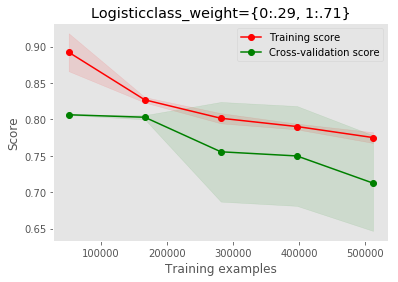

In [11]:
plot_learning_curve(LogisticRegression(solver='liblinear',class_weight={0:.29, 1:.71}), "Logisticclass_weight={0:.29, 1:.71}",
                    X, y,
                    train_sizes=np.linspace(.1, 1.0, 5))

In [20]:
train_X, val_X, train_y, val_y = train_test_split(X, y,test_size=0.8, random_state = 0)
best_log= LogisticRegression(C=0.0001, class_weight='balanced', dual=False, fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

best_log.fit(train_X, train_y)
y_best_log =best_log.predict(val_X)
print(classification_report(val_y, y_best_log))
print(best_log.score(val_X, val_y))

C:\Users\thaliarodrigue\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\thaliarodrigue\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\thaliarodrigue\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.81      1.00      0.89    495974
           1       0.00      0.00      0.00    118839

   micro avg       0.81      0.81      0.81    614813
   macro avg       0.40      0.50      0.45    614813
weighted avg       0.65      0.81      0.72    614813

0.806707080039


<module 'matplotlib.pyplot' from 'C:\\Users\\thaliarodrigue\\AppData\\Local\\Continuum\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

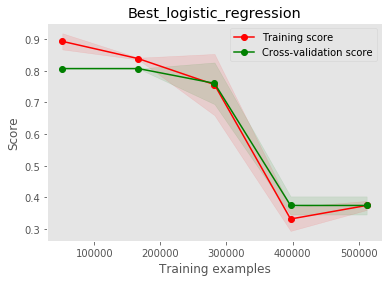

In [15]:
plot_learning_curve(best_log,'Best_logistic_regression',
                    X, y,
                    train_sizes=np.linspace(.1, 1.0, 5))

In [9]:
train_X, val_X, train_y, val_y = train_test_split(X, y,test_size=0.8, random_state = 0)
best_forest=RandomForestClassifier(bootstrap=True, class_weight={0: 0.4, 1: 0.6}, criterion='gini', max_depth=None, max_features=95, max_leaf_nodes=None, min_impurity_decrease=0.0,  min_impurity_split=None, min_samples_leaf=1,min_samples_split=2, min_weight_fraction_leaf=0.0,  n_estimators=90, n_jobs=None, oob_score=False, random_state=None, verbose=0, warm_start=False)
best_forest.fit(train_X, train_y)
y_best_forest =best_forest.predict(val_X)
print(classification_report(val_y, y_best_forest))
print(best_forest.score(val_X, val_y))


              precision    recall  f1-score   support

           0       0.81      0.96      0.88    495974
           1       0.28      0.06      0.11    118839

   micro avg       0.79      0.79      0.79    614813
   macro avg       0.54      0.51      0.49    614813
weighted avg       0.71      0.79      0.73    614813

0.786263465476


<module 'matplotlib.pyplot' from 'C:\\Users\\thaliarodrigue\\AppData\\Local\\Continuum\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

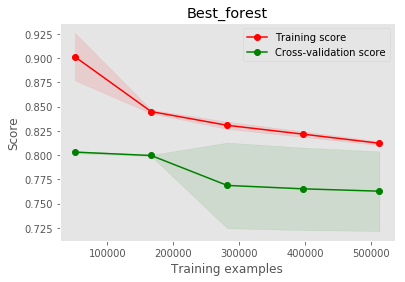

In [17]:
plot_learning_curve(best_forest,'Best_forest',
                    X, y,
                    train_sizes=np.linspace(.1, 1.0, 5))

In [14]:
train_X, val_X, train_y, val_y = train_test_split(X, y,test_size=0.8, random_state = 0)
best_tree=DecisionTreeClassifier(class_weight={0: 0.4, 1: 0.6}, criterion='gini', max_depth=1, max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,  min_weight_fraction_leaf=0.0, presort=False, random_state=None, splitter='best')
best_tree.fit(train_X, train_y)
y_best_tree =best_tree.predict(val_X)
print(classification_report(val_y, y_best_tree))
print(best_tree.score(val_X, val_y))


C:\Users\thaliarodrigue\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\thaliarodrigue\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\thaliarodrigue\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.81      1.00      0.89    495974
           1       0.00      0.00      0.00    118839

   micro avg       0.81      0.81      0.81    614813
   macro avg       0.40      0.50      0.45    614813
weighted avg       0.65      0.81      0.72    614813

0.806707080039


<module 'matplotlib.pyplot' from 'C:\\Users\\thaliarodrigue\\AppData\\Local\\Continuum\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

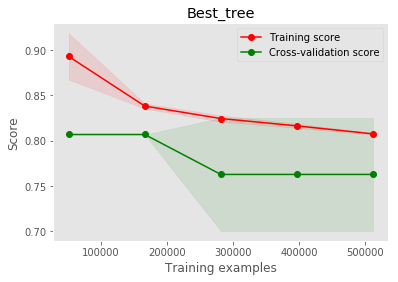

In [21]:
plot_learning_curve(best_tree,'Best_tree',
                    X, y,
                    train_sizes=np.linspace(.1, 1.0, 5))

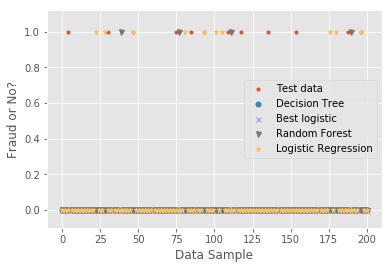

In [22]:
preds=pd.DataFrame()
preds['validation']=val_y
preds['tree']=y_best_tree
preds['logistic']= y_pred_log
preds['forest']=y_best_forest
preds['best_logistic']=y_best_log

preds.describe()
pr=preds.sample(n=100)
ind = np.linspace(0,200,100)# len(val_y),len(val_y))
plt.xlabel('Data Sample')
plt.ylabel('Fraud or No?') 

plt.plot(ind, pr['validation'],'.', markersize=6,label='Test data' )
plt.plot(ind,pr['tree'], 'o', markersize=5,label='Decision Tree')
plt.plot(ind,pr['best_logistic'], 'x', markersize=5,label='Best logistic')
plt.plot(ind,pr['forest'], 'v', markersize=5,label='Random Forest')
plt.plot(ind,pr['logistic'], '*', markersize=5,label='Logistic Regression')
plt.legend(loc='right')
plt.ylim(-.1,1.12)
plt.show()